# Setup

## Load packages

In [1]:
install.packages("caret")

library(tidyverse)  # Data wrangling packages.

my_bucket <- Sys.getenv('WORKSPACE_BUCKET')

library(glmnet)
library(dplyr)
library(pROC)
library(broom)
library(caret)

Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: lattice


Attaching package: ‘caret’


The following obj

## Load and merge data

In [2]:
name_of_file_in_bucket <- 'Demographic_and_ancestry_covariates.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
demo  <- read_csv(name_of_file_in_bucket) |> 
    select(-c(income, education)) |> 
    rename(age = age_at_last_event)

name_of_file_in_bucket <- 'SES_data.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
ses_data  <- read_csv(name_of_file_in_bucket)

all_data <- merge(
  demo,
  ses_data,
  by = "person_id"
)

name_of_file_in_bucket <- 'Case_Control_df.csv'
system(paste0("gsutil cp gs://fc-secure-672eeb92-4859-4ed9-9f59-d4349f3534a0/notebooks/Case_Control_df.csv ."), intern=T)
case_control  <- read_csv(name_of_file_in_bucket)

merged_data<-merge(all_data, case_control, on="person_id", how="inner")

character(0)

Rows: 135557 Columns: 51
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (9): SexGender, ancestry_pred, education, where_born, military, health...
dbl  (30): person_id, race_unknown, age_today, PC_1, PC_2, PC_3, PC_4, PC_5,...
lgl   (8): AIAN, Asian, Black, Mid, Multiple, PI, White, His
dttm  (1): basics_survey_datetime
date  (3): date_of_birth, min_date, max_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

Rows: 214915 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (11): person_id, income, education, per_poverty_threshold, fraction_assi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

Rows: 265954 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): person_id, Asthma, Afib, BreastC, CKD, CHD, HyperC, ProstateC, t2d...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Format data

In [3]:
merged_data <- merged_data %>%
  mutate(
    SexGenderCis_male = ifelse(SexGender == "Cis_male", 1, 0),
    SexGenderCis_female = ifelse(SexGender == "Cis_female", 1, 0),
    SexGenderSGM = ifelse(SexGender == "SGM", 1, 0)
  )

merged_data$age2 <- merged_data$age^2

domains<-c('per_poverty_threshold', 'education', 
           'fraction_assisted_income', 'fraction_high_school_edu', 'median_income', 
           'fraction_no_health_insurance', 'fraction_poverty', 'fraction_vacant_housing', 'deprivation_index')       


#Hard code to match disease names in case_control dataframe 
diseases<-c("Asthma", "Afib", "BreastC", "CKD", "CHD", "ProstateC", "t2d", "t1d")

# Elastic Net Function

In [4]:
run_elastic_net <- function(diseases, selection_terms, merged_data) {
  
  ####---------------------------------------------------------------
  #### 1. Set up output structure
  ####---------------------------------------------------------------
  
  columns <- c("mean_train_score", "sd_train_score", 
               "mean_test_score", "sd_test_score", 
               "mean_AUC", "sd_AUC",
               "n_predictors", "Predictors",
               "mean_coef", "sd_coef", 
               "coef_nonzero_count")
  
  elastic_net_results <- setNames(
    data.frame(matrix(ncol = length(columns), nrow = length(diseases))),
    columns
  )
  rownames(elastic_net_results) <- diseases
  
  all_scores <- list()
  weights_list <- list()   
    
  
  ####---------------------------------------------------------------
  #### 2. Loop through diseases
  ####---------------------------------------------------------------
  
  for (disease in diseases) {
    
    df <- merged_data %>%
      select(all_of(c("person_id", disease, selection_terms))) %>%
      drop_na()
    
    X <- as.matrix(df %>% select(all_of(selection_terms)))
    y <- as.numeric(df[[disease]])
    
    penalty_factors <- rep(1, ncol(X))
    
    n_splits <- 5
    train_scores <- c()
    test_scores  <- c()
    aucs         <- c()
    coef_map     <- list()
    
    set.seed(123)
    
    
    ####---------------------------------------------------------------
    #### 3. 5-fold CV for performance estimation
    ####---------------------------------------------------------------
    
    for (i in 1:n_splits) {
      
      train_index <- createDataPartition(y, p = 0.7, list = FALSE)
      
      X_train <- X[train_index, , drop = FALSE]
      X_test  <- X[-train_index, , drop = FALSE]
      y_train <- y[train_index]
      y_test  <- y[-train_index]
      
      # Scaling — train only
      scale_min <- apply(X_train, 2, min)
      scale_max <- apply(X_train, 2, max)
      scale_range <- scale_max - scale_min
      scale_range[scale_range == 0] <- 1
      
      X_train <- sweep(X_train, 2, scale_min, "-")
      X_train <- sweep(X_train, 2, scale_range, "/")
      
      X_test <- sweep(X_test, 2, scale_min, "-")
      X_test <- sweep(X_test, 2, scale_range, "/")
      
      cv_model <- cv.glmnet(
        X_train, y_train,
        alpha = 0.5, family = "binomial",
        penalty.factor = penalty_factors
      )
      
      best_lambda <- cv_model$lambda.min
      
      final_model <- glmnet(
        X_train, y_train,
        alpha = 0.5, lambda = best_lambda,
        family = "binomial",
        penalty.factor = penalty_factors
      )
      
      model_eval <- assess.glmnet(cv_model, newx = X_train, newy = y_train)
      
      coef_vec <- as.vector(coef(final_model))
      names(coef_vec) <- rownames(coef(final_model))
      coef_map[[i]] <- coef_vec
      
      preds_test <- predict(final_model, newx = X_test, type = "link")
      test_scores <- c(test_scores, cor(preds_test, y_test))
      
      train_scores <- c(train_scores, cv_model$cvm[cv_model$lambda == best_lambda])
      
      aucs <- c(aucs, as.numeric(model_eval$auc))
    }
    
    
    ####---------------------------------------------------------------
    #### 4. Summaries from CV (just for reporting)
    ####---------------------------------------------------------------
    
    coef_df <- bind_rows(lapply(coef_map, \(x) as.data.frame(t(x))))
    coef_df[is.na(coef_df)] <- 0
    
    coef_means <- colMeans(coef_df)
    coef_sds   <- apply(coef_df, 2, sd)
    coef_nonzero_counts <- colSums(coef_df != 0)
    
    
    ####---------------------------------------------------------------
    #### 5. *** Full-data refit for TRUE final weights ***
    ####---------------------------------------------------------------
    
    scale_min_full <- apply(X, 2, min)
    scale_max_full <- apply(X, 2, max)
    scale_range_full <- scale_max_full - scale_min_full
    scale_range_full[scale_range_full == 0] <- 1
    
    X_full_scaled <- sweep(X, 2, scale_min_full, "-")
    X_full_scaled <- sweep(X_full_scaled, 2, scale_range_full, "/")
    
    # CV on full dataset → best λ
    cv_full <- cv.glmnet(
      X_full_scaled, y,
      alpha = 0.5, family = "binomial",
      penalty.factor = penalty_factors
    )
    
    lambda_best <- cv_full$lambda.min
    
    # Final refit using all data
    final_full_model <- glmnet(
      X_full_scaled, y,
      alpha = 0.5, lambda = lambda_best,
      family = "binomial",
      penalty.factor = penalty_factors
    )
    
    coef_final <- as.vector(as.matrix(coef(final_full_model)))
    names(coef_final) <- rownames(coef(final_full_model))
    
    # store in list for weights file later
    weights_list[[disease]] <- coef_final
    
    
    ####---------------------------------------------------------------
    #### 6. Predictions for all individuals
    ####---------------------------------------------------------------
    
    Xb <- X_full_scaled %*% coef_final[-1] + coef_final[1]
    
    all_scores[[disease]] <- data.frame(
      person_id = df$person_id,
      prediction = as.vector(Xb)
    )
    
    
    ####---------------------------------------------------------------
    #### 7. Populate results table
    ####---------------------------------------------------------------
    
    nz <- coef_final[-1] != 0
    nonzero_predictors <- names(coef_final[-1])[nz]
    
    elastic_net_results[disease, "mean_train_score"] <- mean(train_scores)
    elastic_net_results[disease, "sd_train_score"]   <- sd(train_scores)
    elastic_net_results[disease, "mean_test_score"]  <- mean(test_scores)
    elastic_net_results[disease, "sd_test_score"]    <- sd(test_scores)
    elastic_net_results[disease, "mean_AUC"]         <- mean(aucs)
    elastic_net_results[disease, "sd_AUC"]           <- sd(aucs)
    
    elastic_net_results[disease, "n_predictors"]       <- length(nonzero_predictors)
    elastic_net_results[disease, "Predictors"]         <- paste(nonzero_predictors, collapse = ",")
    elastic_net_results[disease, "mean_coef"]          <- paste(round(coef_final[nonzero_predictors], 6), collapse = ",")
    elastic_net_results[disease, "sd_coef"]            <- paste(round(coef_sds[names(coef_sds) %in% nonzero_predictors], 6), collapse = ",")
    elastic_net_results[disease, "coef_nonzero_count"] <- paste(coef_nonzero_counts[names(coef_nonzero_counts) %in% nonzero_predictors], collapse = ",")
    
    message(paste("Completed Elastic Net for:", disease))
  }
  
  elastic_net_results$Disease <- rownames(elastic_net_results)
  
  
  ####---------------------------------------------------------------
  #### 8. Create weights-long and weights-wide tables
  ####---------------------------------------------------------------
  
  weights_long <- bind_rows(lapply(names(weights_list), function(d) {
    cf <- weights_list[[d]]
    data.frame(
      Disease = d,
      Predictor = names(cf),
      weight = as.numeric(cf)
    )
  })) 
  
  weights_wide <- weights_long %>%
    pivot_wider(names_from = Disease, values_from = weight)
  
  
  ####---------------------------------------------------------------
  #### 9. Return everything
  ####---------------------------------------------------------------
  
  return(list(
    model_summary     = elastic_net_results,
    individual_scores = all_scores,
    weights_long      = weights_long,
    weights_wide      = weights_wide
  ))
}



# Run ENs

In [5]:
results_all <- run_elastic_net(diseases, domains, merged_data)


Completed Elastic Net for: Asthma

Completed Elastic Net for: Afib

Completed Elastic Net for: BreastC

Completed Elastic Net for: CKD

Completed Elastic Net for: CHD

Completed Elastic Net for: ProstateC

Completed Elastic Net for: t2d

Completed Elastic Net for: t1d



In [6]:
selection_terms_no_income<-c('education', 
           'fraction_assisted_income', 'fraction_high_school_edu', 'median_income', 
           'fraction_no_health_insurance', 'fraction_poverty', 'fraction_vacant_housing', 'deprivation_index')       


results_no_income <- run_elastic_net(diseases, selection_terms_no_income, merged_data)


Completed Elastic Net for: Asthma

Completed Elastic Net for: Afib

Completed Elastic Net for: BreastC

Completed Elastic Net for: CKD

Completed Elastic Net for: CHD

Completed Elastic Net for: ProstateC

Completed Elastic Net for: t2d

Completed Elastic Net for: t1d



# Save files

## Reporting

In [7]:
write_excel_csv(results_all[[1]], 'elastic_net_results.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./elastic_net_results.csv ", my_bucket, "/data/"), intern=T)

write_excel_csv(results_no_income[[1]], 'elastic_net_results_no_income.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./elastic_net_results_no_income.csv ", my_bucket, "/data/"), intern=T)

character(0)

character(0)

## Weights Files

In [8]:
write_excel_csv(results_all[[4]], 'PsRS_weights_file.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./PsRS_weights_file.csv ", my_bucket, "/data/"), intern=T)


write_excel_csv(results_no_income[[4]], 'PsRS_weights_file_no_income.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./PsRS_weights_file_no_income.csv ", my_bucket, "/data/"), intern=T)

character(0)

character(0)

# Calculate PsRS using AoU weights

In [9]:
name_of_file_in_bucket <- 'PsRS_weights_file_no_income.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
PsRS_weights_no_income <- read_csv(name_of_file_in_bucket)

name_of_file_in_bucket <- 'PsRS_weights_file.csv'
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)
PsRS_weights <- read_csv(name_of_file_in_bucket)

character(0)

Rows: 9 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Predictor
dbl (8): Asthma, Afib, BreastC, CKD, CHD, ProstateC, t2d, t1d

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

Rows: 10 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Predictor
dbl (8): Asthma, Afib, BreastC, CKD, CHD, ProstateC, t2d, t1d

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## PsRS with income

In [10]:
#Scale data
all_data <- all_data %>%
  mutate(across(all_of(domains), ~ (.-min(., na.rm = TRUE)) / 
                               (max(., na.rm = TRUE) - min(., na.rm = TRUE))))


all_data <- all_data |> select("person_id", domains)


# ---- 0. Add intercept column ----
all_data_with_intercept <- all_data %>%
  mutate(`(Intercept)` = 1)

# ---- 1. Pivot all_data to long including intercept ----
long_data <- all_data_with_intercept %>%
  select(person_id, all_of(domains), `(Intercept)`) %>%
  pivot_longer(
    cols = c(all_of(domains), `(Intercept)`),
    names_to = "Predictor",
    values_to = "value"
  )

# ---- 2. Pivot weights to long ----
weights_long <- PsRS_weights %>%
  pivot_longer(
    cols = all_of(diseases),
    names_to = "disease",
    values_to = "coef"
  )

# ---- 3. Join and compute partial score ----
joined <- long_data %>%
  left_join(weights_long, by = "Predictor", relationship = "many-to-many") %>%
  mutate(score_part = value * coef)

# ---- 4. Summarize into full scores per disease per person ----
score_wide <- joined %>%
  group_by(person_id, disease) %>%
  summarize(score = sum(score_part, na.rm = TRUE), .groups = "drop") %>%
  pivot_wider(
    names_from = disease,
    values_from = score,
    values_fill = 0
  ) %>%
  rename_with(~ paste0(., "_PsRS"), -person_id)

write_excel_csv(score_wide, 'individual_PsRS.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./individual_PsRS.csv ", my_bucket, "/data/"), intern=T)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(domains)

  # Now:
  data %>% select(all_of(domains))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


character(0)

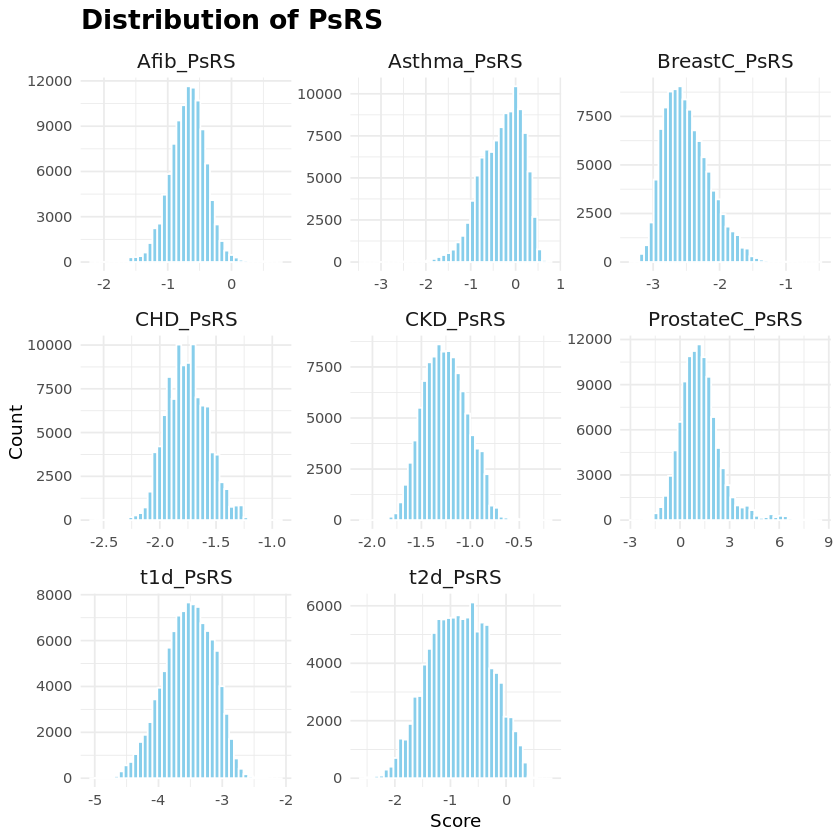

In [11]:
# Pivot to long format
scores_long <- score_wide %>%
  pivot_longer(
    cols = ends_with("_PsRS"),
    names_to = "disease",
    values_to = "score"
  )

# Plot facet-wrapped histograms
ggplot(scores_long, aes(x = score)) +
  geom_histogram(bins = 40, fill = "skyblue", color = "white") +
  facet_wrap(~ disease, scales = "free") +
  theme_minimal() +
  labs(
    title = "Distribution of PsRS",
    x = "Score",
    y = "Count"
  ) +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    strip.text = element_text(size = 12)
  )


## PsRS without income

character(0)

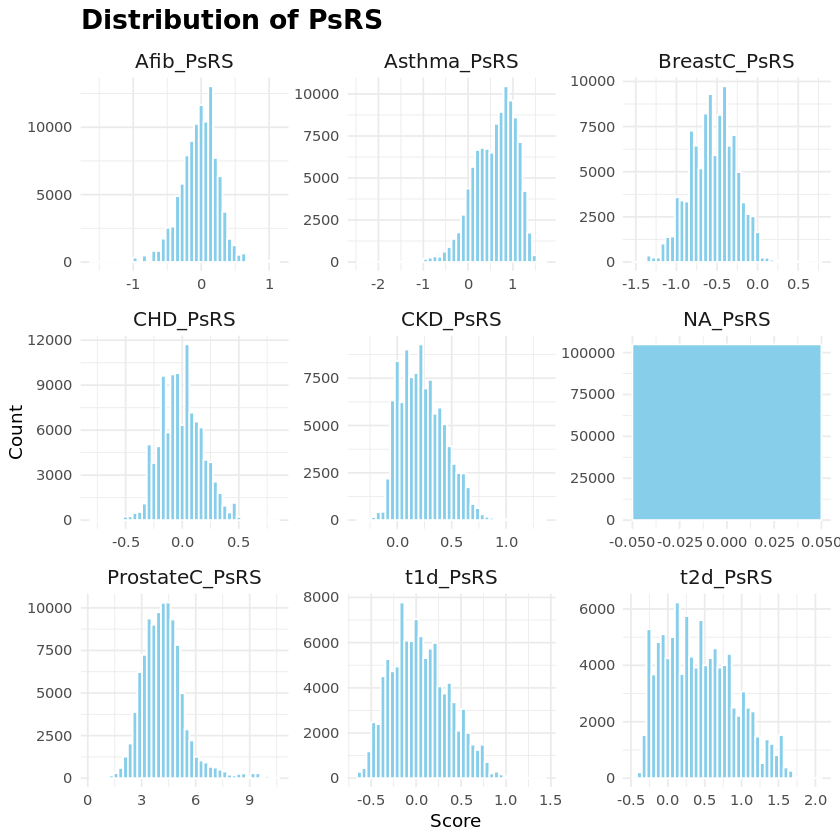

In [12]:
# ---- 1. Pivot all_data to long ----
long_data <- all_data %>%
  select(person_id, all_of(domains)) %>%
  pivot_longer(
    cols = all_of(domains),
    names_to = "Predictor",
    values_to = "value"
  )

# ---- 2. Pivot weights to long ----
weights_long <- PsRS_weights_no_income %>%
  pivot_longer(
    cols = all_of(diseases),
    names_to = "disease",
    values_to = "coef"
  )

# ---- 3. Join and compute partial score ----
joined <- long_data %>%
  left_join(weights_long, by = "Predictor", relationship= "many-to-many") %>%
  mutate(score_part = value * coef)

# ---- 4. Summarize into full scores per disease per person ----
score_wide <- joined %>%
  group_by(person_id, disease) %>%
  summarize(score = sum(score_part, na.rm = TRUE), .groups = "drop") %>%
  pivot_wider(
    names_from = disease,
    values_from = score,
    values_fill = 0
  ) %>%
  rename_with(~ paste0(., "_PsRS"), -person_id)

write_excel_csv(score_wide, 'individual_PsRS_no_income.csv')
# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./individual_PsRS_no_income.csv ", my_bucket, "/data/"), intern=T)

# Pivot to long format
scores_long <- score_wide %>%
  pivot_longer(
    cols = ends_with("_PsRS"),
    names_to = "disease",
    values_to = "score"
  )

# Plot facet-wrapped histograms
ggplot(scores_long, aes(x = score)) +
  geom_histogram(bins = 40, fill = "skyblue", color = "white") +
  facet_wrap(~ disease, scales = "free") +
  theme_minimal() +
  labs(
    title = "Distribution of PsRS",
    x = "Score",
    y = "Count"
  ) +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    strip.text = element_text(size = 12)
  )
